## Adaboost

> Data Import & Cleaning

In [20]:

import pandas as pd
import numpy as np
df_raw = pd.read_csv("Pick224-2021-11-04.csv")

cols=["SEASON", "GP", "EV P1/GP","PP P1/GP", "P1/GP","EV G","EV A1","EV A2","EV P1","PP G","PP A1","PP A2","PP P1","SH G","SH A1","SH A2","EV SHOTS", "EV SH%","PP SHOTS", "PP SH%", "SHOTS", "S%", "TG","TP1","TP","TP/GP","Goals/P1","EV GF","EV GA","EV GF%","EV GF%Rel","OFF EV GF","OFF EV GA","eTOI/GP","P1/e60","AGE SEPT 15","AGE DEC 31"]
colsToDrop = ["HEATMAP"]
cutoff = len(df_raw)/2 # cutoff for feature exclusion
for x in cols:
    if(len(df_raw[df_raw[x]==0]) > cutoff): # if more than half of the column values are 0
        print("Drop:",x)
        colsToDrop.append(x)

colsToDrop.extend(["PLAYER ID", "SEASON", "#"])
colsToDrop.extend(["DOB","AGE DEC 31"]) # The standard NHL cutoff is Sept 15 for draft eligiblity, so we'll stick with that column
colsToDrop.extend(["NHL DRAFT","NHL TEAM", "DRAFT YEAR"])
# The TEAM column is interesting, but not sure how we would use this as there are:
df_raw["TEAM"].value_counts()
#       355 unique teams mentioned. I dont think we are interested in dealing with 355 dummy vars, so I'll drop this as well
colsToDrop.append("TEAM")
colsToDrop.append("DY+/-")
df = df_raw.drop(columns=colsToDrop)

# Format the height
df["HT"] = df["HT"].apply(lambda x : (float(x.split('\'')[0]) + float(x.split('\'')[1])/12) if (x!='-') else np.NaN)
df['HT'] = df['HT'].fillna(df.groupby('POS')['HT'].transform('mean'))

# Prepare dummy vars
# For Leagues, there were options for almost 20 different leagues, so I chose the most recognizable 6:
    # OHL - Ontario Hockey League
    # WHL - Western Hockey League (This covers most of western Canada & United States)
    # QMJHL - Quebec Major Junior League 
    # NCAA - National Collegiate Athletic Association (American college players only)
    # SHL - Swedish Hockey League
    # AHL - American Hockey League
df = pd.get_dummies(df, prefix='League_',columns=['LEAGUE'])
# We will similarly need dummies for POS (This is just F-forward, or D-defense)
df = pd.get_dummies(df, prefix="Position_",columns=["POS"])
# Finally, handedness , right, left, or unknown
df["SHOOTS"] = df["SHOOTS"].replace({"-":"Unknown"})
df = pd.get_dummies(df, prefix="Shoots_",columns=["SHOOTS"])

# Drafted=1 if player was drafted to an nhl team, 0 otherwise
df["Drafted"]=df["DRAFT TEAM"].apply(lambda x: np.where(x=="-",0,1))
df = df.drop(columns=["DRAFT TEAM"])

# Remove whitspaces from negative numbers for column -  EV GF%Rel
df.iloc[:,21] = df.iloc[:,21].str.replace(' ','')
#Format EV GF%Rel
df["EV GF%Rel"] = df["EV GF%Rel"].apply(lambda x : float(x))



Drop: SH G
Drop: SH A1
Drop: SH A2
Drop: EV SHOTS
Drop: EV SH%
Drop: PP SHOTS
Drop: PP SH%
Drop: SHOTS
Drop: S%


> Adaboost - Simple Implementation

In [21]:
#-----------------------------------------------------
# Adaboost
#-----------------------------------------------------
# We begin with a simple implementation

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

row, col = df.shape
x =  df.iloc[:,1:col-1] # Predictors: Everything
y =  df['Drafted'] # Target
#split into training and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3) 

abc = AdaBoostClassifier(n_estimators=50, learning_rate=1) # Try random hyper parameters
#abc = AdaBoostClassifier(n_estimators=200, learning_rate=0.5) # Try random hyper parameters


model = abc.fit(x_train, y_train)

y_pred = model.predict(x_test)
precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
#print('support: {}'.format(support))

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

precision: [0.80025445 0.72284644]
recall: [0.89473684 0.55142857]
fscore: [0.84486232 0.62560778]
Accuracy: 0.7806267806267806


> Hyperparameter Tuning

Best: 0.776735 using {'learning_rate': 0.5, 'n_estimators': 200}
0.728254 (0.019658) with: {'learning_rate': 0.0001, 'n_estimators': 10}
0.728254 (0.019658) with: {'learning_rate': 0.0001, 'n_estimators': 20}
0.728254 (0.019658) with: {'learning_rate': 0.0001, 'n_estimators': 50}
0.728254 (0.019658) with: {'learning_rate': 0.0001, 'n_estimators': 70}
0.728254 (0.019658) with: {'learning_rate': 0.0001, 'n_estimators': 100}
0.728254 (0.019658) with: {'learning_rate': 0.0001, 'n_estimators': 150}
0.728254 (0.019658) with: {'learning_rate': 0.0001, 'n_estimators': 200}
0.728254 (0.019658) with: {'learning_rate': 0.0001, 'n_estimators': 300}
0.728254 (0.019658) with: {'learning_rate': 0.0001, 'n_estimators': 400}
0.728254 (0.019658) with: {'learning_rate': 0.0001, 'n_estimators': 500}
0.728254 (0.019658) with: {'learning_rate': 0.001, 'n_estimators': 10}
0.728254 (0.019658) with: {'learning_rate': 0.001, 'n_estimators': 20}
0.728254 (0.019658) with: {'learning_rate': 0.001, 'n_estimators': 

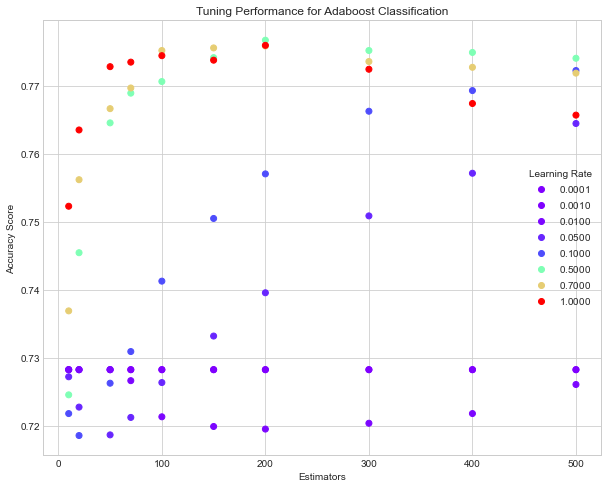

In [22]:
## Now we need to tune these hyperparameters to achieve optimal performance
# Note: This takes ~ 6 minutes, so just trust that we ran it and have optimal parameters
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# use same x, y as before

# define the model with default hyperparameters
model = AdaBoostClassifier()

# define the grid of values to search
grid = dict()
grid['n_estimators'] = [10, 20, 50,70, 100, 150,200,300,400,500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 0.7, 1.0]

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result1 = grid_search.fit(x, y)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))

# summarize all scores that were evaluated
means1 = grid_result1.cv_results_['mean_test_score']
stds1 = grid_result1.cv_results_['std_test_score']
params1 = grid_result1.cv_results_['params']
for mean1, stdev1, param1 in zip(means1, stds1, params1):
    print("%f (%f) with: %r" % (mean1, stdev1, param1))

# Take note of the optimal performance:
   # n_estimators=200, learning rate=0.5 results in an accuracy score of  0.777 (0.019)
# Visualize
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
x2 = [params1[i]['n_estimators'] for i in range(len(params1))]
z2 = [params1[i]['learning_rate'] for i in range(len(params1))]
y2 = means1

fig, ax = plt.subplots()
fig.set_size_inches(10,8)
scatter = ax.scatter(x2, y2, c=z2, cmap='rainbow')
handles, labels = scatter.legend_elements(prop="colors", alpha=1.0)
legend  = ax.legend(handles, labels, loc="center right", title="Learning Rate")
ax.grid(True)
plt.xlabel("Estimators")
plt.ylabel("Accuracy Score")
plt.title("Tuning Performance for Adaboost Classification")
plt.show()


## Compare with other classification algorithms

> Logistic Regression

In [26]:

from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold

# prepare the cross-validation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# create model
model2 = LogisticRegression()
# evaluate model
scores2 = cross_val_score(model2, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores2), std(scores2)))

precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, y_pred)

print('precision: {}'.format(precision,2))
print('recall: {}'.format(recall,2))
print('fscore: {}'.format(fscore,2))


# Optimal classification performance:
   # accuracy=0.752 (0.021)



Accuracy: 0.753 (0.023)
precision: [0.80025445 0.72284644]
recall: [0.89473684 0.55142857]
fscore: [0.84486232 0.62560778]


>  Random Forest

Best: 0.766380 using {'max_depth': 8, 'n_estimators': 300}


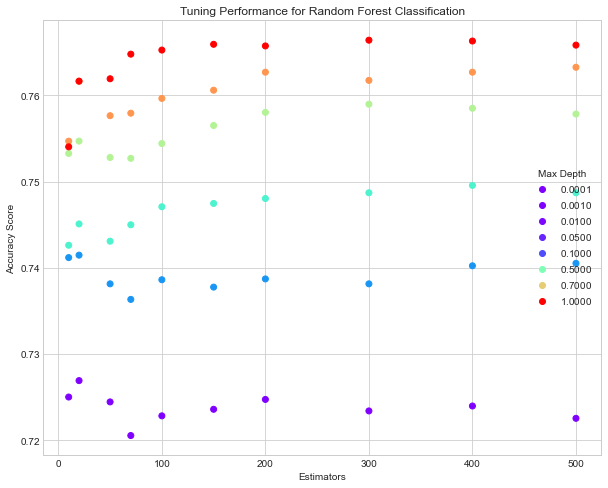

In [9]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
model3 = RandomForestClassifier(random_state=1) # Use bootstrap sampling
# Hyperparam tuning
grid2 = dict()
grid2['n_estimators'] = [10, 20, 50,70, 100, 150,200,300,400,500]
grid2['max_depth'] = [3,4,5,6,7,8]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search2 = GridSearchCV(estimator=model3, param_grid=grid2, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result2 = grid_search2.fit(x, y)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
#  n_estimators=300, max_depth=8, score=0.766 (0.021)

means2 = grid_result2.cv_results_['mean_test_score']
params2 = grid_result2.cv_results_['params']
x3 = [params2[i]['n_estimators'] for i in range(len(params2))]
z3 = [params2[i]['max_depth'] for i in range(len(params2))]
y3 = means2
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
scatter2 = ax.scatter(x3, y3, c=z3, cmap='rainbow')
handles2, labels2 = scatter2.legend_elements(prop="colors", alpha=1.0)
legend  = ax.legend(handles, labels, loc="center right", title="Max Depth")
ax.grid(True)
plt.xlabel("Estimators")
plt.ylabel("Accuracy Score")
plt.title("Tuning Performance for Random Forest Classification")
plt.show()




> Gradient Boost

Best: 0.790803 using {'learning_rate': 0.1, 'n_estimators': 100}


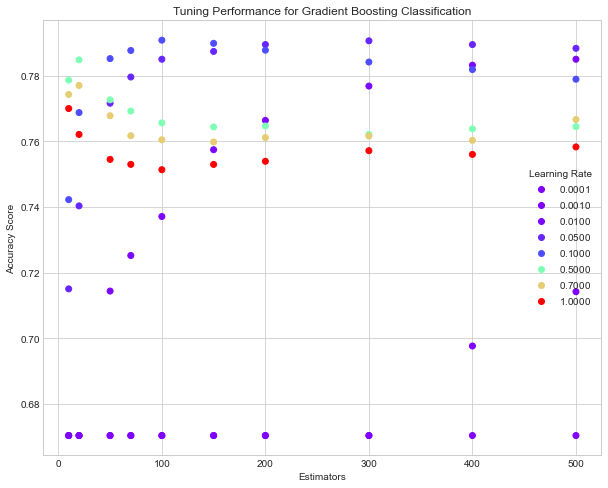

In [10]:
from sklearn.ensemble import GradientBoostingClassifier
model4 = GradientBoostingClassifier(random_state=1)
# Tuning
grid3 = dict()
grid3['n_estimators'] = [10, 20, 50,70, 100, 150,200,300,400,500]
grid3['learning_rate'] = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 0.7, 1.0]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search3 = GridSearchCV(estimator=model4, param_grid=grid3, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result3 = grid_search3.fit(x, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result3.best_score_, grid_result3.best_params_))
#  n_estimators=100, learning_rate=0.1, score=0.791 (0.019)


means3 = grid_result3.cv_results_['mean_test_score']
params3 = grid_result3.cv_results_['params']
x4 = [params3[i]['n_estimators'] for i in range(len(params3))]
z4 = [params3[i]['learning_rate'] for i in range(len(params3))]
y4 = means3
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
scatter3 = ax.scatter(x4, y4, c=z4, cmap='rainbow')
handles3, labels3 = scatter3.legend_elements(prop="colors", alpha=1.0)
legend  = ax.legend(handles3, labels3, loc="center right", title="Learning Rate")
ax.grid(True)
plt.xlabel("Estimators")
plt.ylabel("Accuracy Score")
plt.title("Tuning Performance for Gradient Boosting Classification")
plt.show()




> XGBoost

Best: 0.793656 using {'learning_rate': 0.05, 'n_estimators': 300}


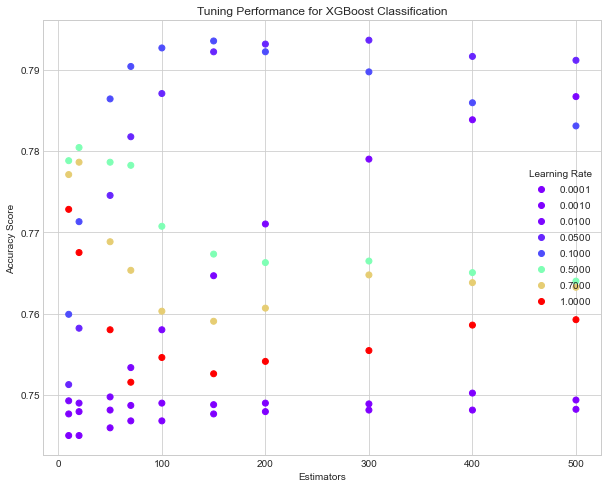

In [11]:

import xgboost as xgb
from xgboost import XGBClassifier

model5 = XGBClassifier(booster='gbtree', max_depth=3, n_jobs=1, random_state=0,eval_metric='rmse', use_label_encoder=False) 
# Hyperparam tuning
grid4 = dict()
grid4['n_estimators'] = [10, 20, 50,70, 100, 150,200,300,400,500]
grid4['learning_rate'] = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 0.7, 1.0]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search4 = GridSearchCV(estimator=model5, param_grid=grid4, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result4 = grid_search4.fit(x, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result4.best_score_, grid_result4.best_params_))
#   n_estimators=300, learning_rate=0.05, score=0.794 (0.019)

means4 = grid_result4.cv_results_['mean_test_score']
params4 = grid_result4.cv_results_['params']
x5 = [params4[i]['n_estimators'] for i in range(len(params4))]
z5 = [params4[i]['learning_rate'] for i in range(len(params4))]
y5 = means4
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
scatter4 = ax.scatter(x5, y5, c=z5, cmap='rainbow')
handles4, labels4 = scatter4.legend_elements(prop="colors", alpha=1.0)
legend  = ax.legend(handles4, labels4, loc="center right", title="Learning Rate")
ax.grid(True)
plt.xlabel("Estimators")
plt.ylabel("Accuracy Score")
plt.title("Tuning Performance for XGBoost Classification")
plt.show()

##    

##   

## 

## 